# Multi armed testbed 

You are faced repeatedly with a choice amoung $k$ different actions or actions. After each choice you receive a numerical reward chosen from a stationary probablity distribution that depends on the action you selected. The objective is to maximize the expected total reward over some time period, for example 1000 action selections or time steps. Given this problem the experiment hypotheizes that near greedy action maximizes the expected reward than the greedy actions.

## Experiment setup

For this experiment we can imagine a slot machine with $k$ arms and for each arm the machine gives us a reward from a sample distribution of mean 0.0 and sd 1. We can the model this distrubtion with the code below.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

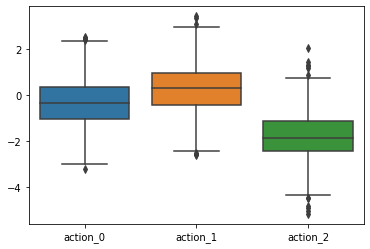

In [2]:
class RewardDistribution:
    def __init__(self, k=10):
        self.k = k
        self.mu = 0
        self.sigma = 1
        self.q_star_mu = np.random.normal(self.mu, self.sigma, k)
        self.q_star_sd = np.ones(k)

    def get_reward(self, action):
        Rt = np.random.normal(self.q_star_mu[action], self.q_star_sd[action], 1)
        return Rt
    
    def plot(self):
        # create a data frame to plot the distribution
        df = {}
        sample_size = 1000
        for action in range(self.k):
            mu = self.q_star_mu[action]
            sd = self.q_star_sd[action]
            df[f'action_{action}'] = np.random.normal(mu, sd, sample_size)
        df = pd.DataFrame(data=df)
        sns.boxplot(data=df)

rd = RewardDistribution(k=3)
rd.plot()

## Hypothesis

near greedy > greedy > non greedy


## Running mean



Let $m_n$ be mean or average value of rewards at $n^{th}$ time step. Let $n$ be the total number of iterations. Let $R_i$ be reward at $i^{th}$ time step.

Then

\begin{equation*}
m_n = \frac{\sum_{i=1}^nR_i}{n}
\newline
m_n = \frac{(\sum_{i=1}^{n-1}R_i)+R_n}{n}
\newline
m_n = \frac{Rn}{n}+\frac{\sum_{i=1}^{n-1}R_{n-1}}{n}
\end{equation*}

The sum of $n-1$ rewards $\sum_{i=1}^{n-1}R_{n-1}$ can also be written as $m_{n-1}$*${n-1}$. Using this the previous equation can be written as

\begin{equation*}
m_n = \frac{Rn}{n} + \frac{(n-1)m_{n-1}}{n}
\end{equation*}

Rearranging terms we get
\begin{equation*}
m_n = m_{n-1}+\frac{R_{n}-m_{n-1}}{n}
\end{equation*}

Which means, just by keep track of current reward $R_{i}$ and running mean $m_{n-1}$ we can update the new mean $m_{n}$ by above equation.

\begin{equation*}
m_n  \Leftarrow m_{n-1}+\frac{R_{n}-m_{n-1}}{n}
\end{equation*}



In [3]:
def running_average(m_n_1, r_i, n):
    m_n = m_n_1 + ((r_i - m_n_1) / n)
    return m_n

## Experiment setup

The goal of this experiment is to compare multi arm bandit problem with greedy and episilon $\epsilon$ greedy approach. In this experiment we will setup 10 arm bandit or a slot machine setup. 

In [4]:
class EpsBandit:
    def __init__(self, rd, k=10, eps=0.0, iterations=10):
        self.k = k
        self.eps = eps
        self.total_avg_reward = 0.0
        self.qa = np.zeros(self.k)
        self.ac = np.zeros(self.k)
        self.iterations = iterations
        self.rd = rd

    def sample_an_action(self):

        def greedy_action():
            # pick action corresponding to high qa
            return np.argmax(self.qa)

        def random_action():
            # pick random action from k selections
            return np.random.choice(self.k)

        if self.eps == 0:
            # always greedy choice
            return greedy_action()
        else:
            p = np.random.rand()
            # high epsilon means more weight to random actions
            if p < self.eps:
                return random_action()
            else:
                return greedy_action()

    def execute_an_action(self, action):
        sampled_rewards = self.rd.get_reward(action=action)
        self.ac[action] += 1
        return sampled_rewards

    def log(self, t, action, r_t):
        print(f'==== step {t} ====')
        print(f'Sampled a reward {r_t} for action A_{action}')
        print(f'Tr {self.total_avg_reward}')
        print(f'qa {self.qa}')
        print(f'ac {self.ac}')
        print('\n')

    def get_total_average_rewards(self):
        return self.total_avg_reward

    def run(self):
        
        avg_reward = [0.0]
        for t in range(1, self.iterations):
            action = self.sample_an_action()
            r_t = self.execute_an_action(action)
            self.total_avg_reward = running_average(m_n_1=self.total_avg_reward, r_i=r_t, n=t)
            self.qa[action] = running_average(m_n_1=self.qa[action], r_i=r_t, n=self.ac[action])
            avg_reward.append(float(self.total_avg_reward))
            #self.log(t, action, r_t)
        return avg_reward

In [5]:

def run_experiment():
    k = 3
    rd = RewardDistribution(k=k)
    
    data = {}
    
    eps_0 = EpsBandit(rd=rd, k=k, eps=0.0, iterations=1000)
    data['eps_0'] = eps_0.run()


    eps_0_0_1 = EpsBandit(rd=rd, k=k, eps=0.01, iterations=1000)
    data['eps_0_0_1'] = eps_0_0_1.run()


    eps_0_1 = EpsBandit(rd=rd, k=k, eps=0.1, iterations=1000)
    data['eps_0_1'] = eps_0_1.run()
    
    return data


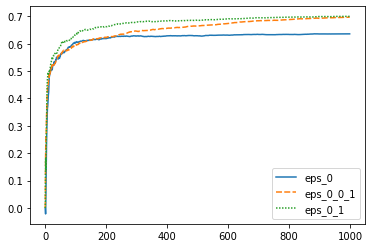

In [6]:
def run_episodes():
    episodes = 100
    result = dict()
    result['eps_0'] = np.zeros(1000)
    result['eps_0_0_1'] = np.zeros(1000)
    result['eps_0_1'] = np.zeros(1000)
    for episode in range(1, episodes):
        df = pd.DataFrame(run_experiment())
        result['eps_0'] = running_average(m_n_1=result['eps_0'], r_i=np.asarray(df['eps_0']), n=episode)
        result['eps_0_0_1'] = running_average(m_n_1=result['eps_0_0_1'], r_i=np.asarray(df['eps_0_0_1']), n=episode)
        result['eps_0_1'] = running_average(m_n_1=result['eps_0_1'], r_i=np.asarray(df['eps_0_1']), n=episode)
        _df = pd.DataFrame(result)
    return _df
sns.lineplot(data=run_episodes())